# Synthetic 1D LECA Introduction

## Import LECA & Standard Python Modules

In [1]:
from LECA import prep, fit, analyze    # LECA Modules
import pandas as pd                    # Pandas DataFrames
import numpy as np                     # Numpy for standard math operations mostly
random_state=0                         # (int) random_state for reproduceability, set to None if this is not desired

## Import Interactive widgets, plots and display

In [2]:
# Magic command for clean inline graphics (inline) or interactive (notebook)
%matplotlib inline
## Imports for interactive widgets
from ipywidgets import interact, widgets, interact_manual
import matplotlib.pyplot as plt
from IPython.display import display
import itertools
from uncertainties import unumpy, ufloat
from importlib import reload

## Define Synthetic experimental setup

In [3]:
# True underlying function f(x) -> y
def f(x):
    """1D Polynomial function for our toy data."""
    return np.ravel(np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2 + 1))


# Synthetic experimental setup with normal measurement error sigma
def run_experiment(x, sigma=0.1, n_resample=3): ## take dataframe -> output dataframe of experimental results
    result = pd.DataFrame(columns=['x','y'])
    for _ in range(n_resample):
        noisy_y = [y + np.random.normal(0, sigma) for y in f(x)]
        single_sample = pd.concat([x, pd.Series(noisy_y, name='y')],axis=1)
        result = pd.concat([result, single_sample],axis=0)
    return result.reset_index(drop=True)



## Initialize DataFrame of experimental measurements

In [4]:
training_data_size = 15
sigma = 0.1 # Measurement noise
n_resample = 3 # How many times a given x is tested for objective function y (generating statistics)

# Generate training dataset
features, objective_functions = 'x', 'y'
starting_data = pd.DataFrame({features: np.linspace(-2,10,training_data_size)}) # sample points for initial model training
df = run_experiment(starting_data[features], sigma, n_resample)
# Use prep.combine_cut to combine repeated measurements
combined_df = prep.combine_cut(df, objective_functions, features)

%matplotlib inline
    
# Initialize plot figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)


n_samples = 100
X = np.linspace(-2, 10, n_samples)
ax.errorbar(X,f(X),label='Ground truth', fmt='--', alpha=0.5,capsize=1)
ax.errorbar(combined_df['x'],combined_df['y'],yerr=1.96*(combined_df['y_std_mean']),xerr=None,label='Training Data', fmt='o', c='black', alpha=0.5,capsize=1)

ax.set_ylabel('y', fontsize=18)
ax.set_xlabel('x', fontsize=18)
ax.tick_params(labelsize=16)
ax.legend()
plt.tight_layout()
plt.show()

Combined 45 datapoints down to 15


## Start workflow and run autoML

In [5]:
wf = fit.WorkFlow(combined_df,
                    [features],
                    objective_functions,
                    random_state=random_state,
                    polynomial_degree=3,
                    validation_holdout=0)
wf.autoML()

Small dataset (n_data < 500), using exclusively GPR models, can manually include other models with WorkFlow.add_regr('<name>', '<type>')
Best performing model for objective y: iMatern_alpha
CV average model score on test (unseen) data MSE: 0.1218300770445662, R2: 0.5670326395256643
Model performance on validation set:
No validation set defined


## Use activeLearn to find expected points of interest

'Query By Committee (maximal uncert):'

x         y     y_std
0  7.046752  0.854403  0.114471

'Expected Improvement'

x         y     y_std
0  2.035587  1.262329  0.074863

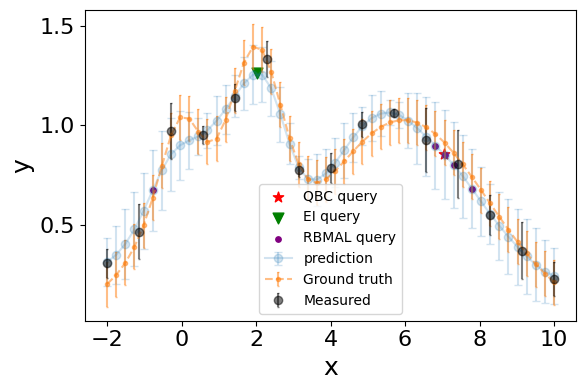

In [6]:
%matplotlib inline
query_ei = wf.optimize('EI', n_restarts_optimizer=10)
query_qbc = wf.optimize('max_uncert', n_restarts_optimizer=10)
display('Query By Committee (maximal uncert):', query_qbc, 'Expected Improvement', query_ei)
    
# Initialize plot figure
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111)


n_samples = 50
X = np.linspace(-2, 10, n_samples)
x_input = pd.DataFrame({'x':X})
pred = wf.predict(x_input, X_scaled=False, min_max=True, return_std=True)
rbmal_queries, _ = wf.RBMAL(pool=x_input, batch_size=5)
ax.errorbar(X,pred['y'],yerr=1.96*(pred['y_std']),xerr=None,label='prediction', fmt='o-', alpha=0.2,capsize=3)
ax.errorbar(X,f(X),yerr=1.96*(sigma)/np.sqrt(3),xerr=None,label='Ground truth', fmt='.--', alpha=0.5,capsize=1)
ax.errorbar(combined_df['x'],combined_df['y'],yerr=1.96*(combined_df['y_std_mean']),xerr=None,label='Measured', fmt='o', c='black', alpha=0.5,capsize=1)
ax.scatter(query_qbc['x'],query_qbc['y'],label='QBC query', marker='*', alpha=1, c='r',s=60)
ax.scatter(query_ei['x'],query_ei['y'],label='EI query', marker='v', alpha=1, c='g',s=60)
ax.scatter(x_input.loc[rbmal_queries]['x'],pred.loc[rbmal_queries]['y'],label='RBMAL query', marker='.', alpha=1, c='purple',s=60)


ax.set_ylabel('y', fontsize=18)
ax.set_xlabel('x', fontsize=18)
ax.tick_params(labelsize=16)
ax.legend()
plt.tight_layout()
plt.show()